Added Shape: vertical_line -> <__main__.VerticalLineDBShape object at 0x71da54695100>
Added Shape: spike -> <__main__.SpikeDBShape object at 0x71da546951c0>
Added Pattern: convex -> <__main__.ConvexPattern object at 0x71da32ead820>
Added Pattern: n_linear_repeat_t_time_sleep -> <__main__.NLinearRepeatTSleepPattern object at 0x71da54695910>
Added Pattern: convex -> <__main__.ConvexPattern object at 0x71da54695190>
Added Pattern: random -> <__main__.RandomPattern object at 0x71da54695280>
Added Pattern: random -> <__main__.RandomPattern object at 0x71da54695a30>
Added Pattern: random -> <__main__.RandomPattern object at 0x71da54695370>
Added Pattern: n_linear_repeat_t_time_sleep -> <__main__.NLinearRepeatTSleepPattern object at 0x71da54695c70>
Added Pattern: linear -> <__main__.LinearPattern object at 0x71da546959a0>
NoisePipeline 적용 완료.


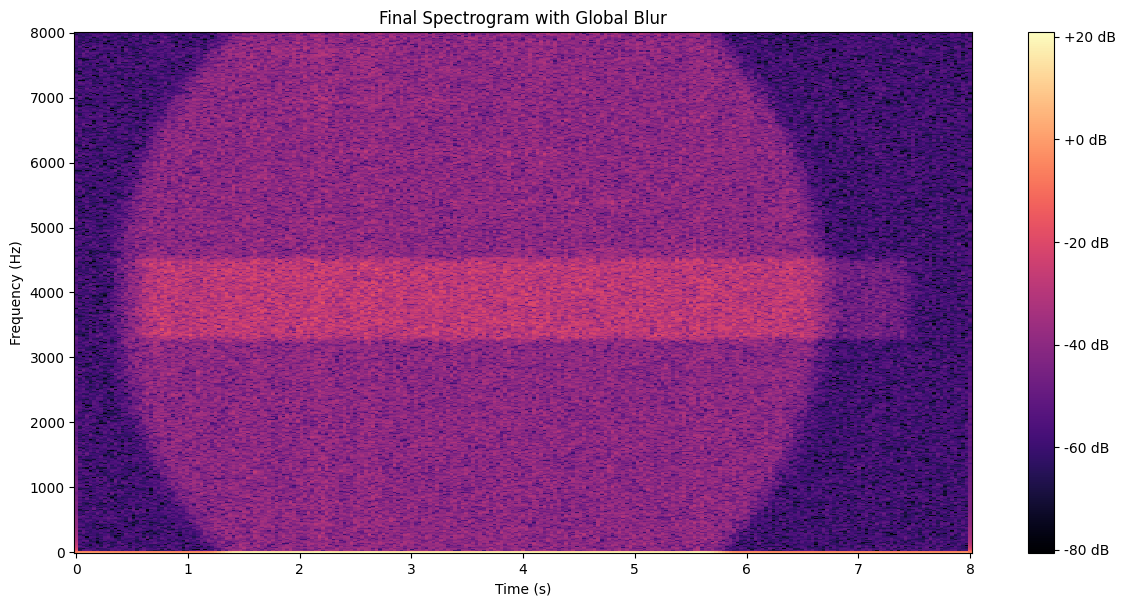

In [65]:
import random
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
from abc import ABC, abstractmethod
from scipy.ndimage import gaussian_filter  # 추가


# =========================================================
# 1) 스펙트로그램 처리 (SpectrogramModifier)
# =========================================================
class SpectrogramModifier:
    def __init__(self, sample_rate=16000, n_fft=1024, hop_length=512,
                 noise_strength=0.1, noise_type='normal', noise_params=None):
        self.sample_rate = sample_rate
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.noise_strength = noise_strength
        self.noise_type = noise_type
        self.noise_params = noise_params if noise_params else {}
        self.signal = None
        self.signal_with_noise = None
        self.S_db = None

    def _generate_normal_noise(self, length, params):
        mean = params.get('mean', 0.0)
        std = params.get('std', 1.0)
        return np.random.normal(mean, std, length)

    def _generate_uniform_noise(self, length, params):
        low = params.get('low', -1.0)
        high = params.get('high', 1.0)
        return np.random.uniform(low, high, length)

    def _generate_perlin_noise(self, length, params):
        def fade(t):
            return 6*t**5 - 15*t**4 + 10*t**3

        seed = params.get('seed', 42)
        np.random.seed(seed)
        perm = np.arange(256)
        np.random.shuffle(perm)
        perm = np.stack([perm, perm]).flatten()
        scale = params.get('scale', 50.0)
        xs = np.linspace(0, length/scale, length)
        xi = np.floor(xs).astype(int)
        xf = xs - xi
        xi = xi % 256
        left_hash = perm[xi]
        right_hash = perm[xi+1]
        u = fade(xf)
        left_grad = ((left_hash & 1)*2-1)*xf
        right_grad = ((right_hash & 1)*2-1)*(xf-1)
        noise = (1-u)*left_grad + u*right_grad
        noise = noise / np.max(np.abs(noise))
        return noise

    def generate_noise(self, signal):
        length = len(signal)
        nt = self.noise_type
        p = self.noise_params
        if nt == 'normal':
            noise = self._generate_normal_noise(length, p)
        elif nt == 'uniform':
            noise = self._generate_uniform_noise(length, p)
        elif nt == 'perlin':
            noise = self._generate_perlin_noise(length, p)
        else:
            noise = np.zeros_like(signal)
        return signal + noise * self.noise_strength

    def compute_spectrogram(self, signal):
        self.signal = signal
        self.signal_with_noise = self.generate_noise(signal)
        S = np.abs(librosa.stft(
            self.signal_with_noise, n_fft=self.n_fft, hop_length=self.hop_length, window='hann'))
        self.S_db = librosa.amplitude_to_db(S, ref=np.max)
        return self.S_db

    def _get_freqs(self):
        return np.linspace(0, self.sample_rate / 2, self.S_db.shape[0])

    def _get_times(self):
        return librosa.frames_to_time(
            np.arange(self.S_db.shape[1]),
            sr=self.sample_rate,
            hop_length=self.hop_length
        )

    def apply_dB_mask(self, dB_mask):
        self.S_db += dB_mask

    def plot_spectrogram(self, show_labels=True, colormap='magma', title='Spectrogram'):
        if self.S_db is None:
            raise ValueError("compute_spectrogram() 먼저 호출")
        fig, ax = plt.subplots(figsize=(12, 6))
        img = librosa.display.specshow(
            self.S_db,
            sr=self.sample_rate,
            hop_length=self.hop_length,
            x_axis='time',
            y_axis='linear',
            ax=ax,
            cmap=colormap
        )
        if show_labels:
            ax.set_xlabel('Time (s)')
            ax.set_ylabel('Frequency (Hz)')
            ax.set_title(title)
            fig.colorbar(img, ax=ax, format="%+2.0f dB")
        else:
            ax.axis('off')
            plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
        plt.tight_layout(pad=0.5)
        return fig, ax


# =========================================================
# 2) 분포 추상화 및 엔진 (Distribution, DistributionEngine)
# =========================================================
class Distribution(ABC):
    @abstractmethod
    def sample(self, shape):
        pass

class NormalDistribution(Distribution):
    def __init__(self, mean, stddev):
        self.mean = mean
        self.stddev = stddev

    def sample(self, shape):
        return np.random.normal(self.mean, self.stddev, shape)

class UniformDistribution(Distribution):
    def __init__(self, min_val, max_val):
        self.min_val = min_val
        self.max_val = max_val
    def sample(self, shape):
        return np.random.uniform(self.min_val, self.max_val, shape)

class NoneDistribution(Distribution):
    def sample(self, shape):
        return np.zeros(shape)

class PoissonDistribution(Distribution):
    def __init__(self, lam=5):
        self.lam = lam
    def sample(self, shape):
        return np.random.poisson(self.lam, shape).astype(float)

class ExponentialDistribution(Distribution):
    def __init__(self, scale=1.0):
        self.scale = scale
    def sample(self, shape):
        noise = np.random.exponential(self.scale, shape)
        noise -= np.mean(noise)
        return noise

class CauchyDistribution(Distribution):
    def sample(self, shape):
        noise = np.random.standard_cauchy(shape)
        noise = np.clip(noise, -10, 10)
        noise = noise / np.max(np.abs(noise))
        return noise

class LaplaceDistribution(Distribution):
    def __init__(self, loc=0.0, scale=1.0):
        self.loc = loc
        self.scale = scale
    def sample(self, shape):
        return np.random.laplace(self.loc, self.scale, shape)

class BetaDistribution(Distribution):
    def __init__(self, a=2.0, b=2.0):
        self.a = a
        self.b = b
    def sample(self, shape):
        noise = np.random.beta(self.a, self.b, shape)
        noise = (noise - 0.5)*2
        return noise

class GammaDistribution(Distribution):
    def __init__(self, shape_param=2.0, scale=1.0):
        self.shape_param = shape_param
        self.scale = scale
    def sample(self, shape):
        noise = np.random.gamma(self.shape_param, self.scale, shape)
        noise -= np.mean(noise)
        noise = noise / (np.std(noise) + 1e-9)
        return noise

class ChiSquareDistribution(Distribution):
    def __init__(self, df=2):
        self.df = df
    def sample(self, shape):
        noise = np.random.chisquare(self.df, shape)
        noise -= np.mean(noise)
        noise = noise / (np.std(noise) + 1e-9)
        return noise


class DistributionEngine:
    def create(self, dist_type, **params):
        dist_type = dist_type.lower()
        if dist_type == "normal":
            return NormalDistribution(params.get('mean', 0), params.get('stddev', 1))
        elif dist_type == "uniform":
            return UniformDistribution(params.get('min', -1), params.get('max', 1))
        elif dist_type == "poisson":
            return PoissonDistribution(params.get('lam', 5))
        elif dist_type == "exponential":
            return ExponentialDistribution(params.get('scale', 1.0))
        elif dist_type == "cauchy":
            return CauchyDistribution()
        elif dist_type == "laplace":
            return LaplaceDistribution(params.get('loc', 0.0), params.get('scale', 1.0))
        elif dist_type == "beta":
            return BetaDistribution(params.get('a', 2.0), params.get('b', 2.0))
        elif dist_type == "gamma":
            return GammaDistribution(params.get('shape_param', 2.0), params.get('scale', 1.0))
        elif dist_type == "chisquare":
            return ChiSquareDistribution(params.get('df', 2))
        else:
            return NoneDistribution()


# =========================================================
# 3) Shape(도형) 계층 (BaseShape, CircleDBShape 등)
# =========================================================
class DBShape(ABC):
    @abstractmethod
    def create_mask(self, spectro_shape, spectro_mod):
        pass

class BaseShape(DBShape):
    def __init__(self, distribution_engine, distribution_type='none', distribution_params=None):
        self.distribution_engine = distribution_engine
        self.distribution_type = distribution_type
        self.distribution_params = distribution_params if distribution_params else {}

    def _sample_distribution(self, shape):
        dist_obj = self.distribution_engine.create(
            self.distribution_type, **self.distribution_params
        )
        return dist_obj.sample(shape)

    @abstractmethod
    def generate_shape_mask(self, spectro_shape, spectro_mod):
        pass

    def create_mask(self, spectro_shape, spectro_mod):
        shape_mask = self.generate_shape_mask(spectro_shape, spectro_mod)
        if self.distribution_type != 'none':
            dist_values = self._sample_distribution(spectro_shape)
            return shape_mask * dist_values
        else:
            return shape_mask


class CircleDBShape(BaseShape):
    def __init__(self, center_freq, center_time, radius_freq, radius_time, strength_dB,
                 distribution_engine, distribution_type='none', distribution_params=None):
        super().__init__(distribution_engine, distribution_type, distribution_params)
        self.center_freq = center_freq
        self.center_time = center_time
        self.radius_freq = radius_freq
        self.radius_time = radius_time
        self.strength_dB = strength_dB

    def generate_shape_mask(self, spectro_shape, spectro_mod):
        freqs = spectro_mod._get_freqs()
        times = spectro_mod._get_times()
        ff, tt = np.meshgrid(freqs, times, indexing='ij')
        dist = ((ff - self.center_freq)**2 / (self.radius_freq**2) +
                (tt - self.center_time)**2 / (self.radius_time**2))
        circle = (dist <= 1).astype(float)
        return circle * self.strength_dB


class TrapezoidDBShape(BaseShape):
    def __init__(self, freq_min, freq_max, time_min, time_max,
                 slope_freq, slope_time, strength_dB,
                 distribution_engine, distribution_type='none', distribution_params=None):
        super().__init__(distribution_engine, distribution_type, distribution_params)
        self.freq_min = freq_min
        self.freq_max = freq_max
        self.time_min = time_min
        self.time_max = time_max
        self.slope_freq = slope_freq
        self.slope_time = slope_time
        self.strength_dB = strength_dB

    def generate_shape_mask(self, spectro_shape, spectro_mod):
        mask = np.zeros(spectro_shape)
        freqs = spectro_mod._get_freqs()
        times = spectro_mod._get_times()
        freq_mask = (freqs >= self.freq_min) & (freqs <= self.freq_max)
        time_mask = (times >= self.time_min) & (times <= self.time_max)
        f_inds = np.where(freq_mask)[0]
        t_inds = np.where(time_mask)[0]
        if len(f_inds) == 0 or len(t_inds) == 0:
            return mask
        f_dist = (freqs[f_inds] - self.freq_min) / (self.freq_max - self.freq_min)
        t_dist = (times[t_inds] - self.time_min) / (self.time_max - self.time_min)
        for i, fi in enumerate(f_inds):
            for j, ti in enumerate(t_inds):
                val = self.strength_dB
                val *= (1 - abs(f_dist[i] - 0.5)*2*self.slope_freq)
                val *= (1 - abs(t_dist[j] - 0.5)*2*self.slope_time)
                mask[fi, ti] += val
        return mask

class SpikeDBShape(BaseShape):
    def __init__(self, distribution_engine,
                 center_freq, center_time,
                 radius_freq, radius_time,
                 strength_dB,
                 rotate=(0, 0),
                 distribution_type='none',
                 distribution_params=None):
        super().__init__(distribution_engine, distribution_type, distribution_params)
        self.center_freq = center_freq
        self.center_time = center_time
        self.radius_freq = radius_freq
        self.radius_time = radius_time
        self.strength_dB = strength_dB
        self.rotate_deg = rotate[0]

    def generate_shape_mask(self, spectro_shape, spectro_mod):
        freqs = spectro_mod._get_freqs()
        times = spectro_mod._get_times()
        ff, tt = np.meshgrid(freqs, times, indexing='ij')

        f_shift = ff - self.center_freq
        t_shift = tt - self.center_time

        angle_rad = np.deg2rad(self.rotate_deg)
        cos_a = np.cos(angle_rad)
        sin_a = np.sin(angle_rad)

        f_rot = f_shift * cos_a - t_shift * sin_a
        t_rot = f_shift * sin_a + t_shift * cos_a

        dist = np.sqrt((f_rot**2)/(self.radius_freq**2) +
                       (t_rot**2)/(self.radius_time**2))
        spike = np.exp(-dist*5) * self.strength_dB
        return spike

class PillarDBShape(BaseShape):
    def __init__(self, freq_min, freq_max, strength_dB,
                 distribution_engine, distribution_type='none', distribution_params=None):
        super().__init__(distribution_engine, distribution_type, distribution_params)
        self.freq_min = freq_min
        self.freq_max = freq_max
        self.strength_dB = strength_dB

    def generate_shape_mask(self, spectro_shape, spectro_mod):
        mask = np.zeros(spectro_shape)
        freqs = spectro_mod._get_freqs()
        freq_indices = np.where((freqs >= self.freq_min) & (freqs <= self.freq_max))[0]
        if len(freq_indices) == 0:
            return mask
        mask[freq_indices, :] += self.strength_dB
        return mask

class RectangleDBShape(BaseShape):
    def __init__(self, freq_min, freq_max, time_min, time_max, strength_dB,
                 distribution_engine, distribution_type='none', distribution_params=None):
        super().__init__(distribution_engine, distribution_type, distribution_params)
        self.freq_min = freq_min
        self.freq_max = freq_max
        self.time_min = time_min
        self.time_max = time_max
        self.strength_dB = strength_dB

    def generate_shape_mask(self, spectro_shape, spectro_mod):
        mask = np.zeros(spectro_shape)
        freqs = spectro_mod._get_freqs()
        times = spectro_mod._get_times()
        freq_indices = np.where((freqs >= self.freq_min) & (freqs <= self.freq_max))[0]
        time_indices = np.where((times >= self.time_min) & (times <= self.time_max))[0]
        if len(freq_indices) == 0 or len(time_indices) == 0:
            return mask
        mask[np.ix_(freq_indices, time_indices)] += self.strength_dB
        return mask

class EllipseDBShape(BaseShape):
    def __init__(self, center_freq, center_time,
                 radius_freq, radius_time,
                 strength_dB,
                 distribution_engine,
                 distribution_type='none',
                 distribution_params=None):
        super().__init__(distribution_engine, distribution_type, distribution_params)
        self.center_freq = center_freq
        self.center_time = center_time
        self.radius_freq = radius_freq
        self.radius_time = radius_time
        self.strength_dB = strength_dB

    def generate_shape_mask(self, spectro_shape, spectro_mod):
        freqs = spectro_mod._get_freqs()
        times = spectro_mod._get_times()
        ff, tt = np.meshgrid(freqs, times, indexing='ij')
        dist = ((ff - self.center_freq)**2/(self.radius_freq**2) +
                (tt - self.center_time)**2/(self.radius_time**2))
        ellipse = (dist <= 1).astype(float)
        return ellipse * self.strength_dB

class HillDBShape(BaseShape):
    def __init__(self, freq_center, time_center,
                 freq_width, time_width,
                 strength_dB,
                 distribution_engine,
                 distribution_type='none',
                 distribution_params=None):
        super().__init__(distribution_engine, distribution_type, distribution_params)
        self.freq_center = freq_center
        self.time_center = time_center
        self.freq_width = freq_width
        self.time_width = time_width
        self.strength_dB = strength_dB

    def generate_shape_mask(self, spectro_shape, spectro_mod):
        freqs = spectro_mod._get_freqs()
        times = spectro_mod._get_times()
        ff, tt = np.meshgrid(freqs, times, indexing='ij')
        dist = np.sqrt(((ff - self.freq_center)**2)/(self.freq_width**2) +
                       ((tt - self.time_center)**2)/(self.time_width**2))
        hill = (1 - dist)
        hill[hill < 0] = 0
        return hill * self.strength_dB

class FogDBShape(BaseShape):
    def __init__(self, strength_dB, coverage=1.0,
                 distribution_engine=None, distribution_type='none',
                 distribution_params=None):
        super().__init__(distribution_engine, distribution_type, distribution_params)
        self.strength_dB = strength_dB
        self.coverage = coverage

    def generate_shape_mask(self, spectro_shape, spectro_mod):
        random_map = np.random.uniform(0, 1, spectro_shape)
        fog = (random_map < self.coverage).astype(float)
        fog *= self.strength_dB * (np.random.randn(*spectro_shape) * 0.1)
        return fog

class PolygonDBShape(BaseShape):
    def __init__(self, vertices, strength_dB,
                 distribution_engine=None, distribution_type='none',
                 distribution_params=None):
        super().__init__(distribution_engine, distribution_type, distribution_params)
        self.vertices = vertices
        self.strength_dB = strength_dB

    def generate_shape_mask(self, spectro_shape, spectro_mod):
        from matplotlib.path import Path
        freqs = spectro_mod._get_freqs()
        times = spectro_mod._get_times()
        ff, tt = np.meshgrid(freqs, times, indexing='ij')

        path = Path(self.vertices)
        points = np.vstack((ff.ravel(), tt.ravel())).T
        inside = path.contains_points(points).reshape(ff.shape)
        mask = np.zeros(spectro_shape)
        mask[inside] = self.strength_dB
        return mask

class WavePatternDBShape(BaseShape):
    def __init__(self, axis='time', frequency=1.0, strength_dB=5.0,
                 distribution_engine=None, distribution_type='none',
                 distribution_params=None):
        super().__init__(distribution_engine, distribution_type, distribution_params)
        self.axis = axis
        self.frequency = frequency
        self.strength_dB = strength_dB

    def generate_shape_mask(self, spectro_shape, spectro_mod):
        freqs = spectro_mod._get_freqs()
        times = spectro_mod._get_times()
        mask = np.zeros(spectro_shape)
        if self.axis == 'time':
            wave = np.sin(2 * np.pi * self.frequency * times)
            mask += wave[np.newaxis, :] * self.strength_dB
        else:
            wave = np.sin(2 * np.pi * self.frequency * freqs)
            mask += wave[:, np.newaxis] * self.strength_dB
        return mask

class RealWorldNoiseDBShape(BaseShape):
    def __init__(self, audio_path, freq_min, freq_max,
                 time_min, time_max, strength_dB=0,
                 distribution_engine=None,
                 distribution_type='none',
                 distribution_params=None):
        super().__init__(distribution_engine, distribution_type, distribution_params)
        self.audio_path = audio_path
        self.freq_min = freq_min
        self.freq_max = freq_max
        self.time_min = time_min
        self.time_max = time_max
        self.strength_dB = strength_dB

    def generate_shape_mask(self, spectro_shape, spectro_mod):
        y, sr = librosa.load(self.audio_path, sr=spectro_mod.sample_rate)
        S = np.abs(librosa.stft(y, n_fft=spectro_mod.n_fft, hop_length=spectro_mod.hop_length))
        S_db = librosa.amplitude_to_db(S, ref=np.max)

        freqs = spectro_mod._get_freqs()
        times = spectro_mod._get_times()
        freq_indices = np.where((freqs >= self.freq_min) & (freqs <= self.freq_max))[0]
        time_indices = np.where((times >= self.time_min) & (times <= self.time_max))[0]

        if len(freq_indices) == 0 or len(time_indices) == 0:
            return np.zeros(spectro_shape)

        f_cut = min(len(freq_indices), S_db.shape[0])
        t_cut = min(len(time_indices), S_db.shape[1])

        mask = np.zeros(spectro_shape)
        mask[freq_indices[:f_cut], time_indices[:t_cut]] += (S_db[:f_cut, :t_cut]
                                                             + self.strength_dB)
        return mask



# 수평 라인
class HorizontalLineDBShape(BaseShape):
    def __init__(self, center_freq, strength_dB,
                 thickness=1,
                 distribution_engine=None,
                 distribution_type='none',
                 distribution_params=None):
        super().__init__(distribution_engine, distribution_type, distribution_params)
        self.center_freq = center_freq
        self.strength_dB = strength_dB
        self.thickness = thickness

    def generate_shape_mask(self, spectro_shape, spectro_mod):
        mask = np.zeros(spectro_shape)
        freqs = spectro_mod._get_freqs()
        freq_idx = np.argmin(np.abs(freqs - self.center_freq))
        start_idx = max(freq_idx - self.thickness//2, 0)
        end_idx = min(freq_idx + self.thickness//2 + 1, spectro_shape[0])
        mask[start_idx:end_idx, :] += self.strength_dB
        return mask


# 수직 라인
class VerticalLineDBShape(BaseShape):
    def __init__(self, center_time, strength_dB,
                 thickness=1,
                 distribution_engine=None,
                 distribution_type='none',
                 distribution_params=None):
        super().__init__(distribution_engine, distribution_type, distribution_params)
        self.center_time = center_time
        self.strength_dB = strength_dB
        self.thickness = thickness

    def generate_shape_mask(self, spectro_shape, spectro_mod):
        mask = np.zeros(spectro_shape)
        times = spectro_mod._get_times()
        time_idx = np.argmin(np.abs(times - self.center_time))
        start_idx = max(time_idx - self.thickness//2, 0)
        end_idx = min(time_idx + self.thickness//2 + 1, spectro_shape[1])
        mask[:, start_idx:end_idx] += self.strength_dB
        return mask


# 수평 분포 HorizontalRangeDistribution
class HorizontalRangeDistributionDBShape(DBShape):
    def __init__(self, freq_min, freq_max,
                 strength_dB,
                 distribution='gaussian',
                 distribution_params=None):
        self.freq_min = freq_min
        self.freq_max = freq_max
        self.strength_dB = strength_dB
        self.distribution = distribution
        self.distribution_params = distribution_params if distribution_params else {}

    def _get_distribution(self, values):
        sigma = self.distribution_params.get('sigma', 5)
        center = (values.min() + values.max()) / 2
        dist = np.exp(-0.5 * ((values - center)/sigma)**2)
        dist /= dist.max()
        return dist

    def create_mask(self, spectro_shape, spectro_mod):
        mask = np.zeros(spectro_shape)
        freqs = spectro_mod._get_freqs()
        freq_indices = np.where((freqs >= self.freq_min) & (freqs <= self.freq_max))[0]
        if len(freq_indices) == 0:
            return mask
        freq_values = freqs[freq_indices]
        dist_values = self._get_distribution(freq_values)
        for i, fi in enumerate(freq_indices):
            mask[fi, :] += self.strength_dB * dist_values[i]
        return mask


# 수직 분포 VerticalRangeDistribution
class VerticalRangeDistributionDBShape(DBShape):
    def __init__(self, time_min, time_max,
                 strength_dB,
                 distribution='gaussian',
                 distribution_params=None):
        self.time_min = time_min
        self.time_max = time_max
        self.strength_dB = strength_dB
        self.distribution = distribution
        self.distribution_params = distribution_params if distribution_params else {}

    def _get_distribution(self, values):
        sigma = self.distribution_params.get('sigma', 0.5)
        center = (values.min() + values.max()) / 2
        dist = np.exp(-0.5 * ((values - center)/sigma)**2)
        dist /= dist.max()
        return dist

    def create_mask(self, spectro_shape, spectro_mod):
        mask = np.zeros(spectro_shape)
        times = spectro_mod._get_times()
        time_indices = np.where((times >= self.time_min) & (times <= self.time_max))[0]
        if len(time_indices) == 0:
            return mask

        time_vals = times[time_indices]
        dist_values = self._get_distribution(time_vals)
        for i, ti in enumerate(time_indices):
            mask[:, ti] += self.strength_dB * dist_values[i]
        return mask


# =========================================================
# 4) Pattern(패턴) 계층 (LinearPattern, RandomPattern 등)
# =========================================================
class Pattern(ABC):
    @abstractmethod
    def create_mask(self, spectro_shape, spectro_mod, shape_factory, distribution_engine):
        pass


class LinearPattern(Pattern):
    def __init__(self, shape_name, shape_params,
                 direction='time', repeat=5, spacing=1.0):
        self.shape_name = shape_name
        self.shape_params = shape_params
        self.direction = direction
        self.repeat = repeat
        self.spacing = spacing

    def create_mask(self, spectro_shape, spectro_mod, shape_factory, distribution_engine):
        mask = np.zeros(spectro_shape)
        for i in range(self.repeat):
            offset = i * self.spacing
            params = self.shape_params.copy()
            if self.direction == 'time' and 'center_time' in params:
                params['center_time'] += offset
            elif self.direction == 'freq' and 'center_freq' in params:
                params['center_freq'] += offset

            shape_obj = shape_factory.create(self.shape_name, **params)
            if shape_obj is not None:
                mask += shape_obj.create_mask(spectro_shape, spectro_mod)
        return mask


class RandomPattern(Pattern):
    def __init__(self, shape_name, shape_params,
                 n=10, freq_range=None, time_range=None):
        self.shape_name = shape_name
        self.shape_params = shape_params
        self.n = n
        self.freq_range = freq_range if freq_range else (0, 8000)
        self.time_range = time_range if time_range else (0, 10)

    def create_mask(self, spectro_shape, spectro_mod, shape_factory, distribution_engine):
        mask = np.zeros(spectro_shape)
        for _ in range(self.n):
            params = self.shape_params.copy()
            if 'center_freq' in params:
                params['center_freq'] = np.random.uniform(*self.freq_range)
            if 'center_time' in params:
                params['center_time'] = np.random.uniform(*self.time_range)

            shape_obj = shape_factory.create(self.shape_name, **params)
            if shape_obj:
                mask += shape_obj.create_mask(spectro_shape, spectro_mod)
        return mask


class NLinearRepeatTSleepPattern(Pattern):
    def __init__(self, shape_name, shape_params,
                 repeat=3, repeat_time=0.5,
                 sleep_time=5.0, start_time=0.0):
        self.shape_name = shape_name
        self.shape_params = shape_params
        self.repeat = repeat
        self.repeat_time = repeat_time
        self.sleep_time = sleep_time
        self.start_time = start_time

    def create_mask(self, spectro_shape, spectro_mod, shape_factory, distribution_engine):
        mask = np.zeros(spectro_shape)
        current_time = self.start_time
        for _ in range(self.repeat):
            params = self.shape_params.copy()
            if 'center_time' in params:
                params['center_time'] = current_time

            shape_obj = shape_factory.create(self.shape_name, **params)
            if shape_obj:
                mask += shape_obj.create_mask(spectro_shape, spectro_mod)
            current_time += self.repeat_time

        current_time += self.sleep_time
        return mask


class ConvexPattern(Pattern):
    def __init__(self, shape_name, shape_params,
                 freq_min, freq_max, time_min, time_max,
                 n=10):
        self.shape_name = shape_name
        self.shape_params = shape_params
        self.freq_min = freq_min
        self.freq_max = freq_max
        self.time_min = time_min
        self.time_max = time_max
        self.n = n

    def create_mask(self, spectro_shape, spectro_mod, shape_factory, distribution_engine):
        mask = np.zeros(spectro_shape)
        freqs = np.linspace(self.freq_min, self.freq_max, self.n)
        times = np.linspace(self.time_min, self.time_max, self.n)
        for i in range(self.n):
            params = self.shape_params.copy()
            if 'center_freq' in params:
                params['center_freq'] = freqs[i]
            if 'center_time' in params:
                params['center_time'] = times[i]

            shape_obj = shape_factory.create(self.shape_name, **params)
            if shape_obj:
                mask += shape_obj.create_mask(spectro_shape, spectro_mod)
        return mask


class FunctionPattern(Pattern):
    def __init__(self, func):
        self.func = func

    def create_mask(self, spectro_shape, spectro_mod, shape_factory, distribution_engine):
        freqs = spectro_mod._get_freqs()
        times = spectro_mod._get_times()
        ff, tt = np.meshgrid(freqs, times, indexing='ij')
        return self.func(ff, tt)


# =========================================================
# 5) 팩토리 (ShapeFactory, PatternFactory)
# =========================================================
class ShapeFactory:
    def __init__(self, distribution_engine):
        self.distribution_engine = distribution_engine

    def create(self, shape_name, **kwargs):
        shape_name = shape_name.lower()
        if shape_name == "circle":
            return CircleDBShape(
                distribution_engine=self.distribution_engine,
                center_freq=kwargs['center_freq'],
                center_time=kwargs['center_time'],
                radius_freq=kwargs['radius_freq'],
                radius_time=kwargs['radius_time'],
                strength_dB=kwargs['strength_dB'],
                distribution_type=kwargs.get('distribution_type', 'none'),
                distribution_params=kwargs.get('distribution_params', None)
            )
        elif shape_name == "trapezoid":
            return TrapezoidDBShape(
                distribution_engine=self.distribution_engine,
                freq_min=kwargs['freq_min'],
                freq_max=kwargs['freq_max'],
                time_min=kwargs['time_min'],
                time_max=kwargs['time_max'],
                slope_freq=kwargs['slope_freq'],
                slope_time=kwargs['slope_time'],
                strength_dB=kwargs['strength_dB'],
                distribution_type=kwargs.get('distribution_type', 'none'),
                distribution_params=kwargs.get('distribution_params', None)
            )
        elif shape_name == "rectangle":
            return RectangleDBShape(
                distribution_engine=self.distribution_engine,
                freq_min=kwargs['freq_min'],
                freq_max=kwargs['freq_max'],
                time_min=kwargs['time_min'],
                time_max=kwargs['time_max'],
                strength_dB=kwargs['strength_dB'],
                distribution_type=kwargs.get('distribution_type', 'none'),
                distribution_params=kwargs.get('distribution_params', None)
            )
        elif shape_name == "ellipse":
            return EllipseDBShape(
                distribution_engine=self.distribution_engine,
                center_freq=kwargs['center_freq'],
                center_time=kwargs['center_time'],
                radius_freq=kwargs['radius_freq'],
                radius_time=kwargs['radius_time'],
                strength_dB=kwargs['strength_dB'],
                distribution_type=kwargs.get('distribution_type', 'none'),
                distribution_params=kwargs.get('distribution_params', None)
            )
        elif shape_name == "fog":
            return FogDBShape(
                distribution_engine=self.distribution_engine,
                strength_dB=kwargs['strength_dB'],
                coverage=kwargs.get('coverage', 1.0),
                distribution_type=kwargs.get('distribution_type', 'none'),
                distribution_params=kwargs.get('distribution_params', None)
            )
        elif shape_name == "polygon":
            return PolygonDBShape(
                distribution_engine=self.distribution_engine,
                vertices=kwargs['vertices'],
                strength_dB=kwargs['strength_dB'],
                distribution_type=kwargs.get('distribution_type', 'none'),
                distribution_params=kwargs.get('distribution_params', None)
            )
        elif shape_name == "wave_pattern":
            return WavePatternDBShape(
                distribution_engine=self.distribution_engine,
                axis=kwargs.get('axis', 'time'),
                frequency=kwargs['frequency'],
                strength_dB=kwargs['strength_dB'],
                distribution_type=kwargs.get('distribution_type', 'none'),
                distribution_params=kwargs.get('distribution_params', None)
            )
        elif shape_name == "real_world_noise":
            return RealWorldNoiseDBShape(
                distribution_engine=self.distribution_engine,
                audio_path=kwargs['audio_path'],
                freq_min=kwargs['freq_min'],
                freq_max=kwargs['freq_max'],
                time_min=kwargs['time_min'],
                time_max=kwargs['time_max'],
                strength_dB=kwargs['strength_dB'],
                distribution_type=kwargs.get('distribution_type', 'none'),
                distribution_params=kwargs.get('distribution_params', None)
            )
        elif shape_name == "spike":
            return SpikeDBShape(
                distribution_engine=self.distribution_engine,
                center_freq=kwargs['center_freq'],
                center_time=kwargs['center_time'],
                radius_freq=kwargs['radius_freq'],
                radius_time=kwargs['radius_time'],
                strength_dB=kwargs['strength_dB'],
                rotate=kwargs.get('rotate', (0, 0)),
                distribution_type=kwargs.get('distribution_type', 'none'),
                distribution_params=kwargs.get('distribution_params', None)
            )
        elif shape_name == "hill":
            return HillDBShape(
                distribution_engine=self.distribution_engine,
                freq_center=kwargs['freq_center'],
                time_center=kwargs['time_center'],
                freq_width=kwargs['freq_width'],
                time_width=kwargs['time_width'],
                strength_dB=kwargs['strength_dB'],
                distribution_type=kwargs.get('distribution_type', 'none'),
                distribution_params=kwargs.get('distribution_params', None)
            )
        elif shape_name == "pillar":
            return PillarDBShape(
                distribution_engine=self.distribution_engine,
                freq_min=kwargs['freq_min'],
                freq_max=kwargs['freq_max'],
                strength_dB=kwargs['strength_dB'],
                distribution_type=kwargs.get('distribution_type', 'none'),
                distribution_params=kwargs.get('distribution_params', None)
            )
        elif shape_name == "horizontal_line":
            return HorizontalLineDBShape(
                distribution_engine=self.distribution_engine,
                center_freq=kwargs['center_freq'],
                strength_dB=kwargs['strength_dB'],
                thickness=kwargs.get('thickness', 1),
                distribution_type=kwargs.get('distribution_type', 'none'),
                distribution_params=kwargs.get('distribution_params', None)
            )
        elif shape_name == "vertical_line":
            return VerticalLineDBShape(
                distribution_engine=self.distribution_engine,
                center_time=kwargs['center_time'],
                strength_dB=kwargs['strength_dB'],
                thickness=kwargs.get('thickness', 1),
                distribution_type=kwargs.get('distribution_type', 'none'),
                distribution_params=kwargs.get('distribution_params', None)
            )
        elif shape_name == "horizontal_range_dist_db":
            return HorizontalRangeDistributionDBShape(
                freq_min=kwargs['freq_min'],
                freq_max=kwargs['freq_max'],
                strength_dB=kwargs['strength_dB'],
                distribution=kwargs.get('distribution', 'gaussian'),
                distribution_params=kwargs.get('distribution_params', {})
            )
        elif shape_name == "vertical_range_dist_db":
            return VerticalRangeDistributionDBShape(
                time_min=kwargs['time_min'],
                time_max=kwargs['time_max'],
                strength_dB=kwargs['strength_dB'],
                distribution=kwargs.get('distribution', 'gaussian'),
                distribution_params=kwargs.get('distribution_params', {})
            )
        else:
            raise ValueError(f"Unknown shape name: {shape_name}")


class PatternFactory:
    def create(self, pattern_name, params):
        pattern_name = pattern_name.lower()
        if pattern_name == "linear":
            return LinearPattern(
                params['shape_name'],
                params['shape_params'],
                params.get('direction', 'time'),
                params.get('repeat', 5),
                params.get('spacing', 1.0)
            )
        elif pattern_name == "random":
            return RandomPattern(
                params['shape_name'],
                params['shape_params'],
                params.get('n', 10),
                params.get('freq_range', (0, 16000)),
                params.get('time_range', (0.0, 12.0))
            )
        elif pattern_name == "n_linear_repeat_t_time_sleep":
            return NLinearRepeatTSleepPattern(
                params['shape_name'],
                params['shape_params'],
                params.get('repeat', 3),
                params.get('repeat_time', 0.5),
                params.get('sleep_time', 5.0),
                params.get('start_time', 0.0)
            )
        elif pattern_name == "convex":
            return ConvexPattern(
                params['shape_name'],
                params['shape_params'],
                params['freq_min'],
                params['freq_max'],
                params['time_min'],
                params['time_max'],
                params.get('n', 10)
            )
        elif pattern_name == "function":
            return FunctionPattern(params['func'])
        else:
            return None


# =========================================================
# 6) NoisePipeline (전역 블러 옵션 추가)
# =========================================================
class NoisePipeline:
    def __init__(self, spectro_mod, apply_blur=False, blur_sigma=1.0):
        self.spectro_mod = spectro_mod
        self.distribution_engine = DistributionEngine()
        self.shape_factory = ShapeFactory(self.distribution_engine)
        self.pattern_factory = PatternFactory()
        self.shapes = []
        self.patterns = []
        self.apply_blur = apply_blur       # 전역 블러 적용 여부
        self.blur_sigma = blur_sigma       # 블러 강도

    def add_shape(self, shape):
        self.shapes.append(shape)
        return self

    def add_pattern(self, pattern):
        if pattern is not None:
            self.patterns.append(pattern)
        return self

    def generate(self, signal):
        spec = self.spectro_mod.compute_spectrogram(signal)
        total_mask = np.zeros_like(spec)

        # 1) 모든 Shape
        for shape in self.shapes:
            shape_mask = shape.create_mask(spec.shape, self.spectro_mod)
            total_mask += shape_mask

        # 2) 모든 Pattern
        for pattern in self.patterns:
            pattern_mask = pattern.create_mask(
                spec.shape, self.spectro_mod,
                self.shape_factory, self.distribution_engine
            )
            total_mask += pattern_mask

        # 3) 전역 블러 후처리
        if self.apply_blur and self.blur_sigma > 0:
            total_mask = gaussian_filter(total_mask, sigma=self.blur_sigma)

        # 4) 스펙트럼에 적용
        self.spectro_mod.apply_dB_mask(total_mask)
        return self.spectro_mod.S_db


# =========================================================
# 7) 예시: 무작위 파라미터 생성
# =========================================================
import random

import random

def generate_shape_params(shape_name, duration, sr, freq_min=20, time_min=0.0, min_float_value=0.001, alpha=1.0):
    """
    도형 생성 파라미터를 랜덤으로 생성하며, alpha 계수를 통해 랜덤성 조정 가능.
    """
    params = {
        "strength_dB": random.uniform(1, 10)
    }

    # freq_min과 freq_max를 완전 랜덤으로 설정
    random_freq_min = random.uniform(freq_min, sr * alpha)
    random_freq_max = random.uniform(freq_min, sr * alpha)
    if random_freq_min > random_freq_max:
        random_freq_min, random_freq_max = random_freq_max, random_freq_min

    # time_min과 time_max를 완전 랜덤으로 설정
    random_time_min = random.uniform(time_min, duration * alpha)
    random_time_max = random.uniform(time_min, duration * alpha)
    if random_time_min > random_time_max:
        random_time_min, random_time_max = random_time_max, random_time_min

    if shape_name in ["circle", "ellipse", "spike"]:
        params.update({
            "center_freq": random.uniform(random_freq_min, random_freq_max),
            "center_time": random.uniform(random_time_min, random_time_max),
            "radius_freq": random.uniform(10, (random_freq_max - random_freq_min) * alpha),
            "radius_time": random.uniform(min_float_value, duration * alpha)
        })
    elif shape_name == "rectangle":
        params.update({
            "freq_min": random_freq_min,
            "freq_max": random_freq_max,
            "time_min": random_time_min,
            "time_max": random_time_max,
        })
    elif shape_name == "pillar":
        params.update({
            "freq_min": random_freq_min,
            "freq_max": random_freq_max,
        })
    elif shape_name in ["horizontal_range_dist_db", "vertical_range_dist_db"]:
        params.update({
            "freq_min" if shape_name.startswith("horizontal") else "time_min": random_freq_min if shape_name.startswith("horizontal") else random_time_min,
            "freq_max" if shape_name.startswith("horizontal") else "time_max": random_freq_max if shape_name.startswith("horizontal") else random_time_max,
            "distribution": "gaussian",
            "distribution_params": {"sigma": random.uniform(1.0 * alpha, 5.0 * alpha)}
        })
    elif shape_name in ["horizontal_line", "vertical_line"]:
        params.update({
            "center_freq" if shape_name == "horizontal_line" else "center_time": random.uniform(random_freq_min, random_freq_max) if shape_name == "horizontal_line" else random.uniform(random_time_min, random_time_max),
            "thickness": random.randint(1, 5)
        })
    return params


def create_random_noise_pipeline(
    spectro_mod,
    max_shapes=5,
    max_patterns=3,
    apply_blur=False,
    blur_sigma=2.0,
    duration=8.0,
    sr=16000,
    freq_min=20,
    min_float_value=0.001,
    alpha=1.0
):
    """
    랜덤성 조정 계수 alpha를 사용하여 파이프라인을 생성.
    """
    pipeline = NoisePipeline(spectro_mod, apply_blur=apply_blur, blur_sigma=blur_sigma)
    shape_factory, pattern_factory = pipeline.shape_factory, pipeline.pattern_factory
    shapes = ["circle", "rectangle", "ellipse", "spike", "fog", "pillar", "horizontal_line", "vertical_line", "horizontal_range_dist_db", "vertical_range_dist_db"]
    patterns = ["linear", "random", "n_linear_repeat_t_time_sleep", "convex"]

    # Shapes 추가
    for _ in range(random.randint(1, max_shapes)):
        sname = random.choice(shapes)
        try:
            shape = shape_factory.create(sname, **generate_shape_params(sname, duration, sr, freq_min, min_float_value=min_float_value, alpha=alpha))
            pipeline.add_shape(shape)
            print(f"Added Shape: {sname} -> {shape}")  # 디버깅 메시지
        except Exception as e:
            print(f"Shape '{sname}' 생성 오류: {e}.")

    # Patterns 추가
    for _ in range(random.randint(1, max_patterns)):
        pname = random.choice(patterns)
        try:
            shape_name = random.choice(shapes)
            pattern_kwargs = {
                "shape_name": shape_name,
                "shape_params": generate_shape_params(shape_name, duration, sr, freq_min, min_float_value=min_float_value, alpha=alpha)
            }
            if pname == "linear":
                pattern_kwargs.update({
                    "direction": random.choice(["time", "freq"]),
                    "repeat": random.randint(1, int(duration * alpha)),
                    "spacing": random.uniform(min_float_value, duration * alpha)
                })
            elif pname == "random":
                pattern_kwargs.update({
                    "n": random.randint(3, int(10 * alpha)),
                    "freq_range": (freq_min, sr),
                    "time_range": (0.0, duration * alpha)
                })
            elif pname == "n_linear_repeat_t_time_sleep":
                pattern_kwargs.update({
                    "repeat": random.randint(1, int(duration * alpha)),
                    "repeat_time": random.uniform(min_float_value, duration * alpha),
                    "sleep_time": random.uniform(min_float_value, duration * alpha),
                    "start_time": random.uniform(0.0, duration * alpha)
                })
            elif pname == "convex":
                pattern_kwargs.update({
                    "freq_min": random.uniform(freq_min, sr * alpha),
                    "freq_max": random.uniform(freq_min, sr * alpha),
                    "time_min": random.uniform(0.0, duration * alpha),
                    "time_max": random.uniform(0.0, duration * alpha),
                    "n": random.randint(3, int(6 * alpha))
                })
            pattern = pattern_factory.create(pname, pattern_kwargs)
            pipeline.add_pattern(pattern)
            print(f"Added Pattern: {pname} -> {pattern}")  # 디버깅 메시지
        except Exception as e:
            print(f"Pattern '{pname}' 생성 오류: {e}.")

    return pipeline




# ===========================
# spectrogram to audio
# ===========================
def reconstruct_with_griffinlim(spectrogram_db, n_iter=32, hop_length=512):
    # dB -> amplitude
    amplitude = librosa.db_to_amplitude(spectrogram_db, ref=1.0)
    # Griffin-Lim
    new_audio = librosa.griffinlim(
        amplitude,
        n_iter=n_iter,
        hop_length=hop_length,
        window='hann'
    )
    return new_audio


def reconstruct_audio_from_final_spectrogram(spectro_mod, hop_length=512):
    """
    NoisePipeline을 거쳐 최종 S_db가 완성된 spectro_mod 객체로부터
    다시 시간영역 신호를 복원한다. (원 신호의 위상 사용)
    """
    # 1) 노이즈 섞인 신호로 STFT를 다시 구해, 위상 정보를 얻는다.
    stft_orig = librosa.stft(
        spectro_mod.signal_with_noise,
        n_fft=spectro_mod.n_fft,
        hop_length=spectro_mod.hop_length,
        window='hann'
    )
    phase = np.angle(stft_orig)  # 위상만 추출

    # 2) 최종 스펙트로그램(dB) -> 선형 진폭(amplitude) 변환
    magnitude = librosa.db_to_amplitude(spectro_mod.S_db, ref=1.0)
    #    ref=1.0 대신, 원 신호의 최대치나 다른 값을 사용할 수도 있음

    # 3) 새 STFT = (새 amplitude) * e^(j * (원 위상))
    new_stft = magnitude * np.exp(1j * phase)

    # 4) iSTFT (시간영역 신호 복원)
    new_audio = librosa.istft(
        new_stft,
        hop_length=hop_length,
        window='hann'
    )
    return new_audio



sr = 16000
duration = 8
n_samples = sr * duration
signal = np.random.normal(40, 1, n_samples)

spectro_mod = SpectrogramModifier(
    sample_rate=sr,
    n_fft=1024,
    hop_length=512,
    noise_strength=1,
    noise_type='normal',
    noise_params={'mean': 0.0, 'std': 1.0}
)

pipeline = create_random_noise_pipeline(
    spectro_mod,
    max_shapes=3,
    max_patterns=10,
    apply_blur=True,
    blur_sigma=2.0,
    duration=duration,
    sr=sr,
    freq_min=0,
    min_float_value=0,

)

result_db = pipeline.generate(signal)

print("NoisePipeline 적용 완료.")

# 시각화
spectro_mod.plot_spectrogram(title='Final Spectrogram with Global Blur')
plt.show()

reconstructed = reconstruct_audio_from_final_spectrogram(spectro_mod, hop_length=512)

# 직접 들어보기 (Jupyter/IPython 환경 가정)
import IPython.display as ipd

# Audio 데이터 생성
audio_widget = ipd.Audio(data=reconstructed, rate=sr)
display(audio_widget)


